# Denoising Diffusion Probabilistic Model (DDPM)

[[1](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)] Ho J, Jain A, Abbeel P. Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems. 2020.

[[2](https://huggingface.co/blog/annotated-diffusion)] Rogge N, Rasul K, The Annotated Diffusion Model. 2022.

## Setup

Diffusion models roughly consist of two parts

- a predefined **forward** diffusion process $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise.
- a **reverse** denoising diffusion process $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$, approximated by a neural network, which gradually denoises an image starting from pure noise, until you end up with an actual image.

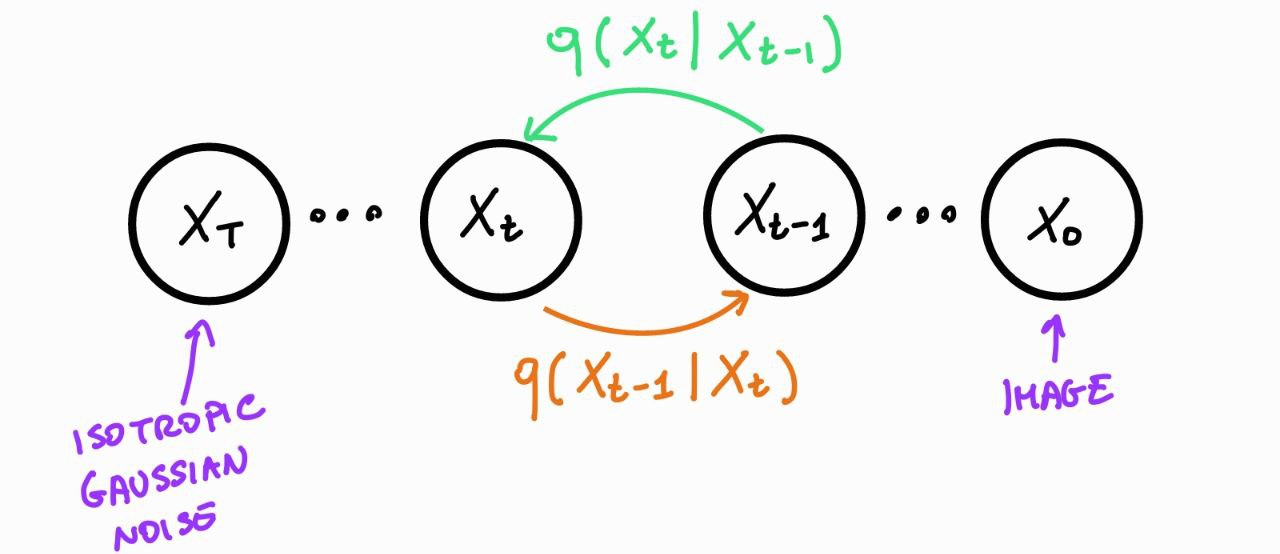

### Forward process

<div>
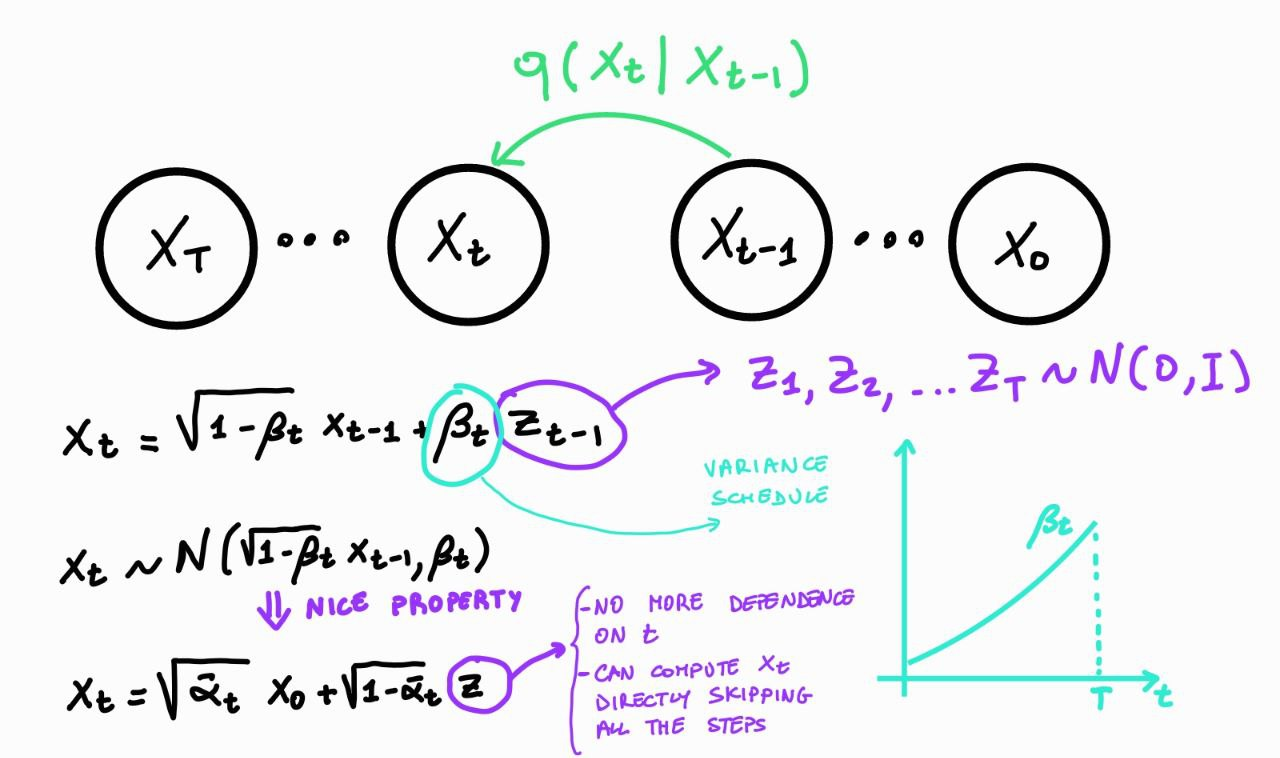
</div>

**Nice property:** Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$

\begin{align}
\boldsymbol{x}_t & = \sqrt{\alpha_t} \boldsymbol{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{z}_{t-1} & \text{where} \;\boldsymbol{z}_{t-1}, \boldsymbol{z}_{t-2}, \dots, \mathcal{N}(\mathbf{0}, \mathbf{I})\\
    & = \sqrt{\alpha_t \alpha_{t-1}} \boldsymbol{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}}\boldsymbol{\bar{z}}_{t-2} & \; \text{where} \boldsymbol{\bar{z}}_{t-2} \text{merges two Gaussians}^1.\\
    & = \dots \\
    & = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{z} \\
q(\boldsymbol{x}_t|\boldsymbol{x}_0)    & = \mathcal{N}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, 1 - \bar{\alpha}_t)
\end{align}

$^1$ the sum of two Gaussian variables $\boldsymbol{z}_1 \sim \mathcal{N}(\mathbf{0}, \sigma_1^2 \mathbf{I})$ and $\boldsymbol{z}_2 \sim \mathcal{N}(\mathbf{0}, \sigma_2^2 \mathbf{I})$ is a new variable $\bar{\boldsymbol{z}} \sim \mathcal{N}(\mathbf{0}, (\sigma_1^2 + \sigma_2^2) \mathbf{I})$. In our case, $\boldsymbol{z}_{t-1} \sim \mathcal{N}(\mathbf{0}, (1-\alpha_t) \mathbf{I})$ and $\boldsymbol{z}_{t-2} \sim \mathcal{N}(\mathbf{0}, \alpha_t(1-\alpha_{t-1}) \mathbf{I})$, so $\boldsymbol{\bar{z}}_{t-2} \sim \mathcal{N}(\mathbf{0}, (1 - \alpha_t \alpha_{t-1}) \mathbf{I})$

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we define the scheduler to compute $\beta_t$. The simplest is the linear scheduler, but more advanced schedulers can give better results.

In [2]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [3]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# calculations for the forward diffusion q(x_t | x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

Let's illustrate how noise is added to a sample image at each time step of the diffusion process.

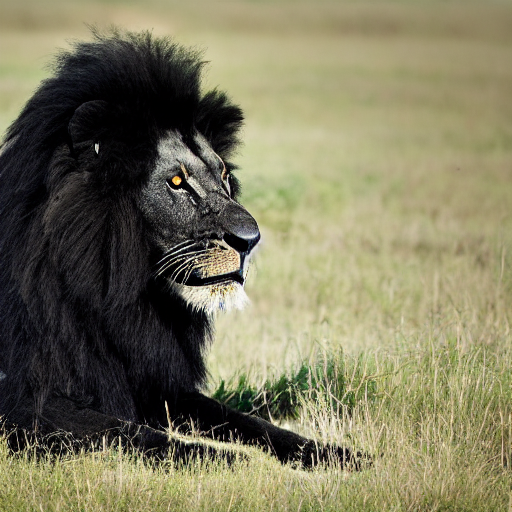

In [5]:
from PIL import Image
image = Image.open("img/lion_short.png")
image

Next, we normalize the image, rescale it in $[-1, 1]$, and convert it to a PyTorch tensor.

In [7]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

We also define the reverse transform, which maps a PyTorch tensor with in $[−1,1]$ back into a PIL image.

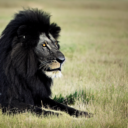

In [33]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())

We can now define the forward diffusion process.

In [18]:
# utility function to extract the appropriate t index for a batch of indices.
# e.g., t=[10,11], x_shape=[16,3,128,128] --> [2,1,1,1]
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start) # z (it does not depend on t!)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

let's test on a specific time step, $t=40$:

In [25]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

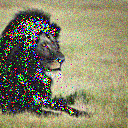

In [39]:
# take time step
t = torch.tensor([20])

get_noisy_image(x_start, t)

In [40]:
def plot_seq(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

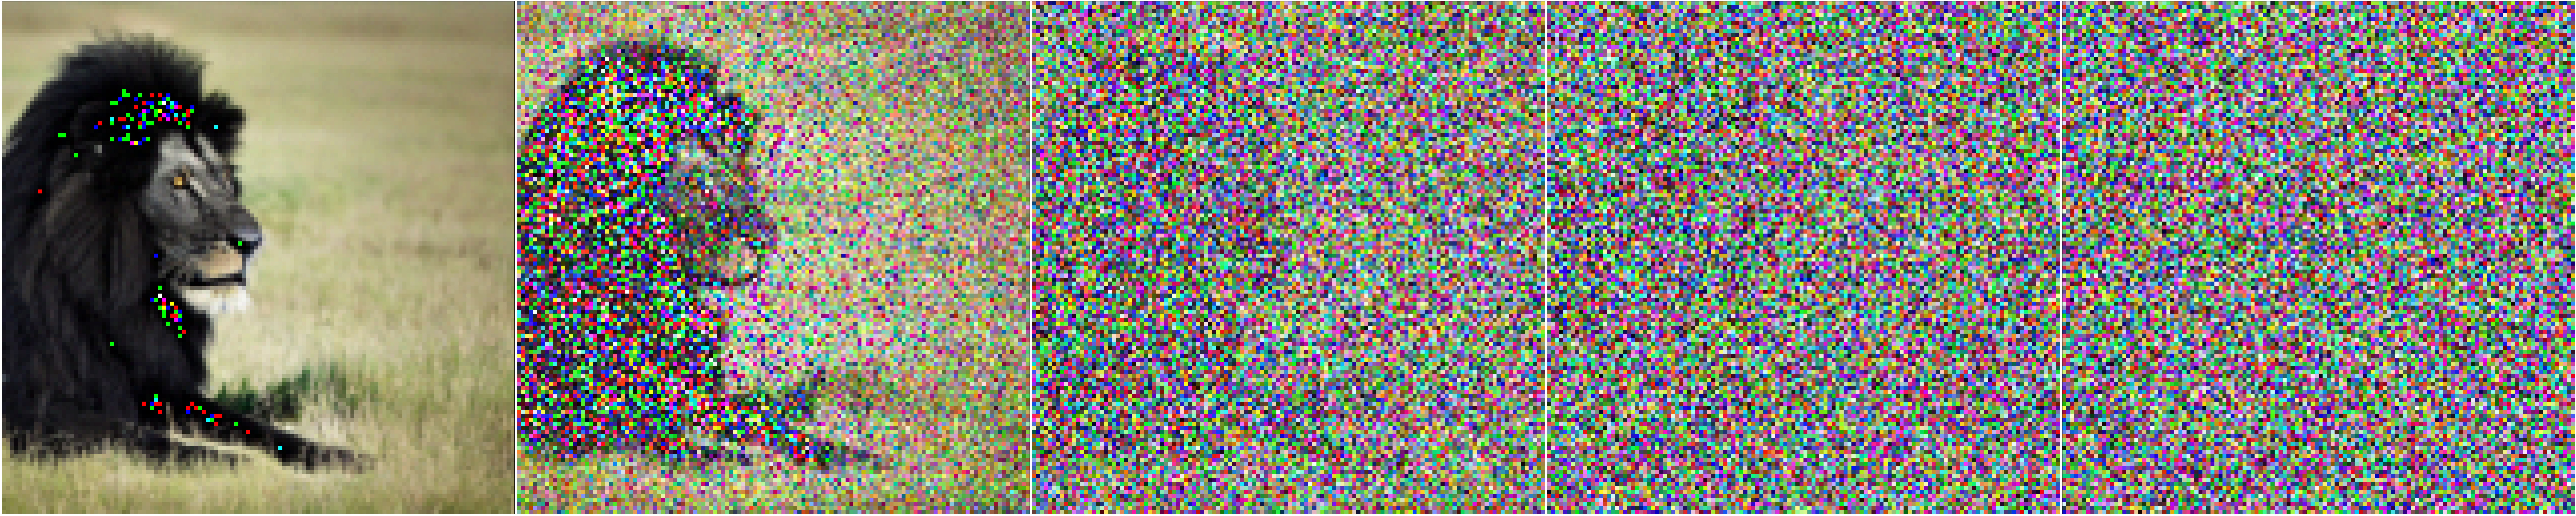

In [41]:
plot_seq([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

## Reverse process

Generate a new sample $\boldsymbol{x}_0$ by sampling pure noise $\boldsymbol{x}_T$ and gradually denoise it.

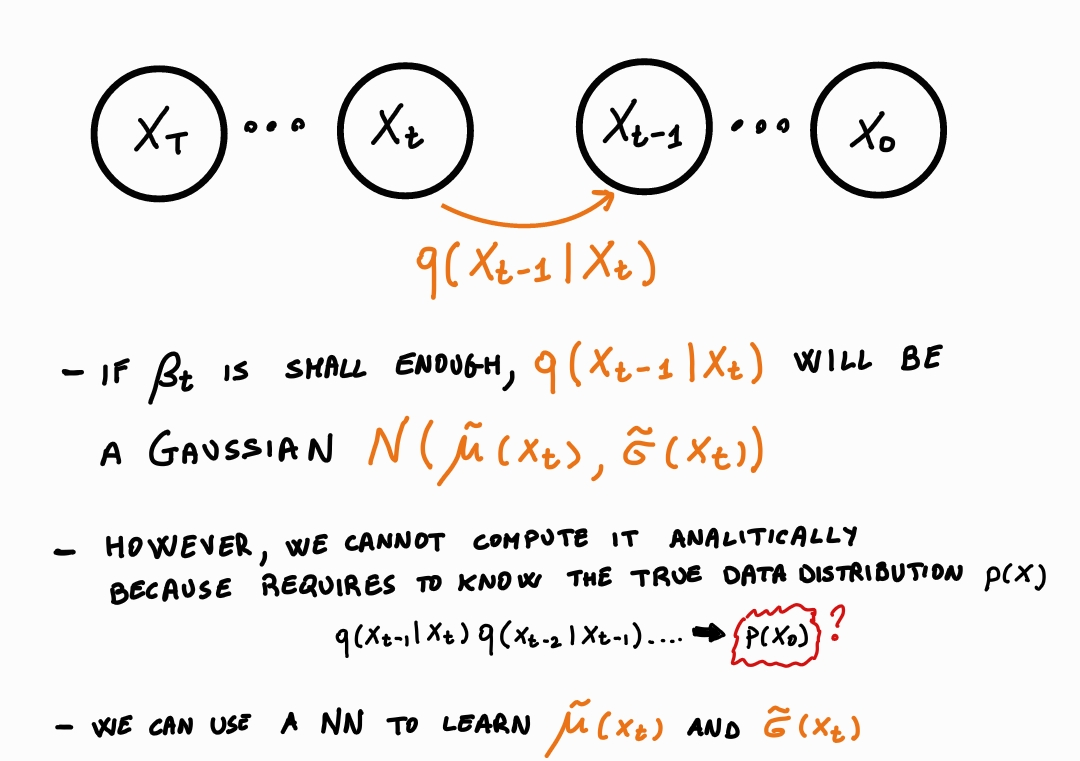

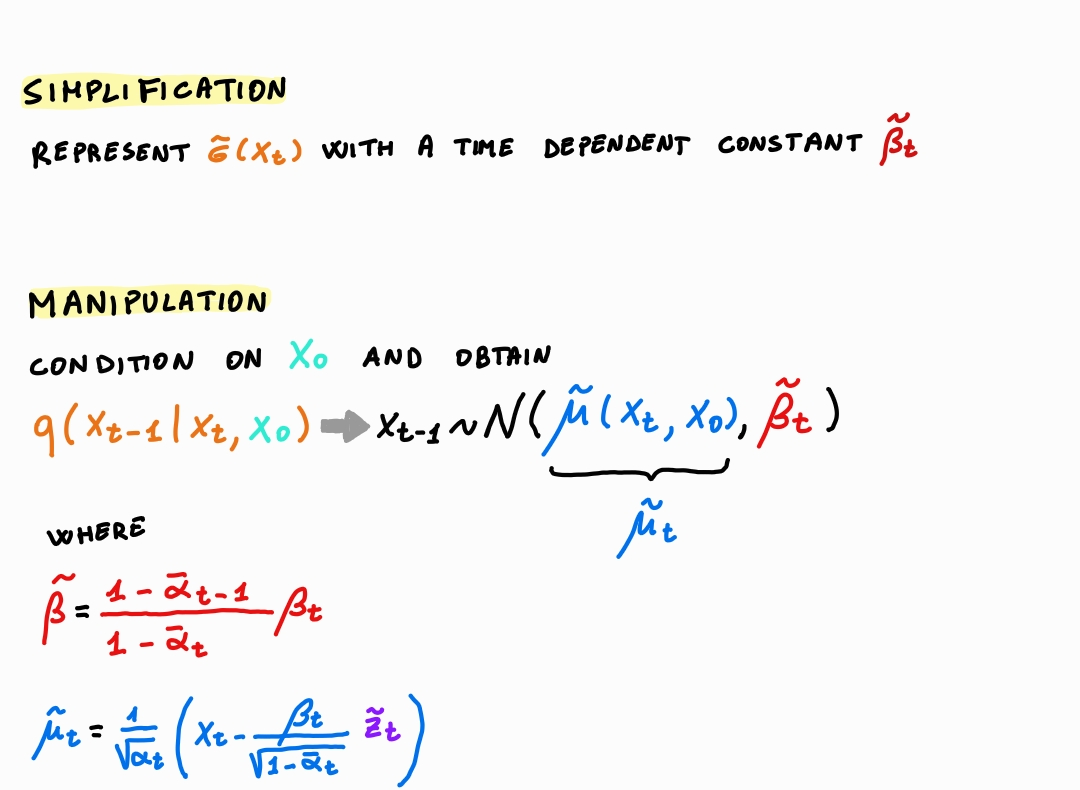

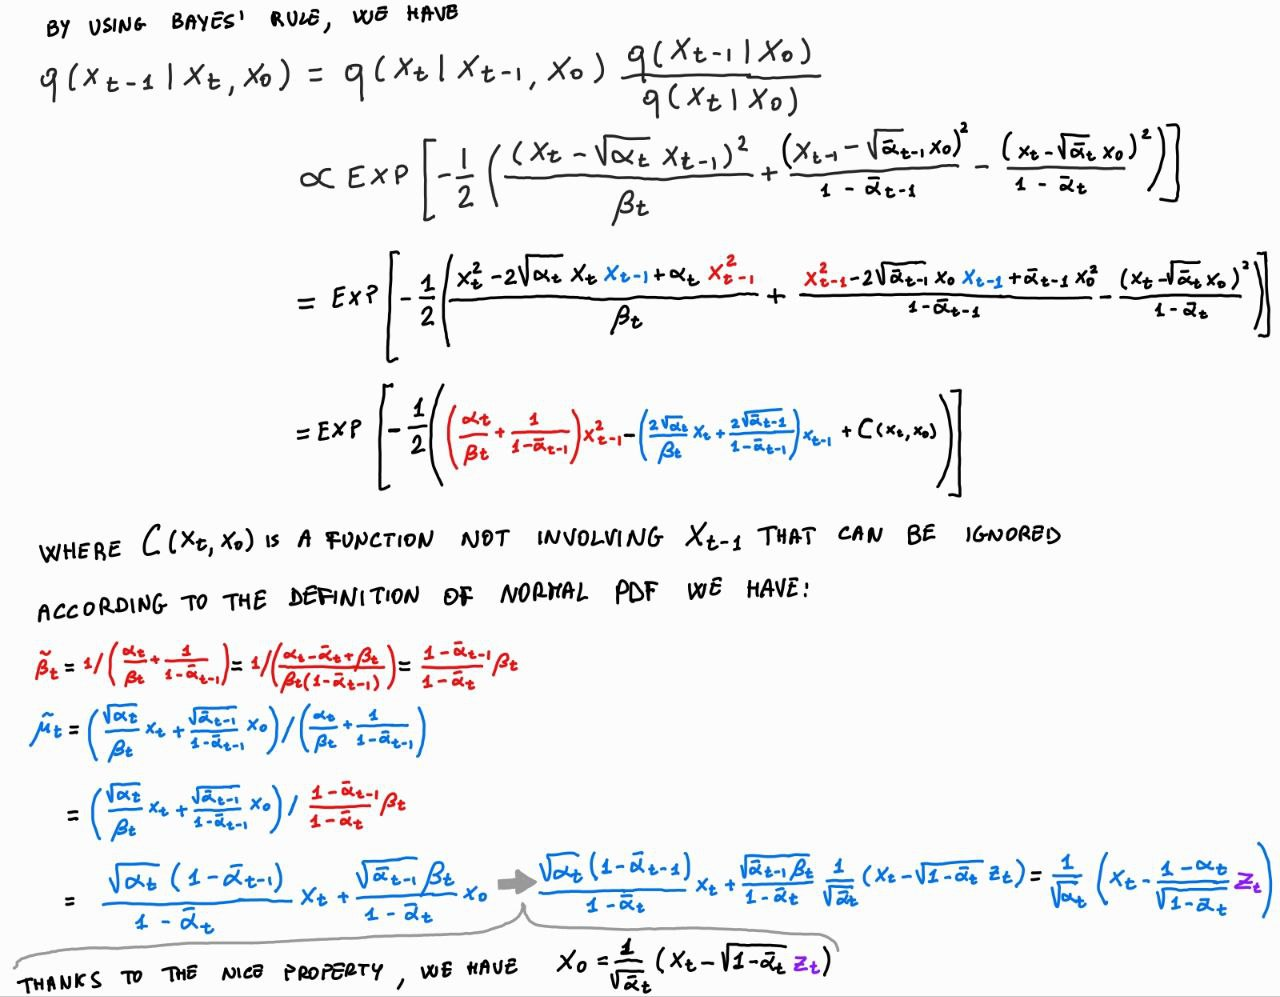

### NN Model

- Looking at $\tilde \mu_t$ and $\tilde \beta_t$, the only thing we do not know is <span style="color:purple"> $\boldsymbol{\tilde z}_t$ </span>. 
- We approximate <span style="color:purple"> $\boldsymbol{\tilde z}_t$ </span> with a NN.

<div>
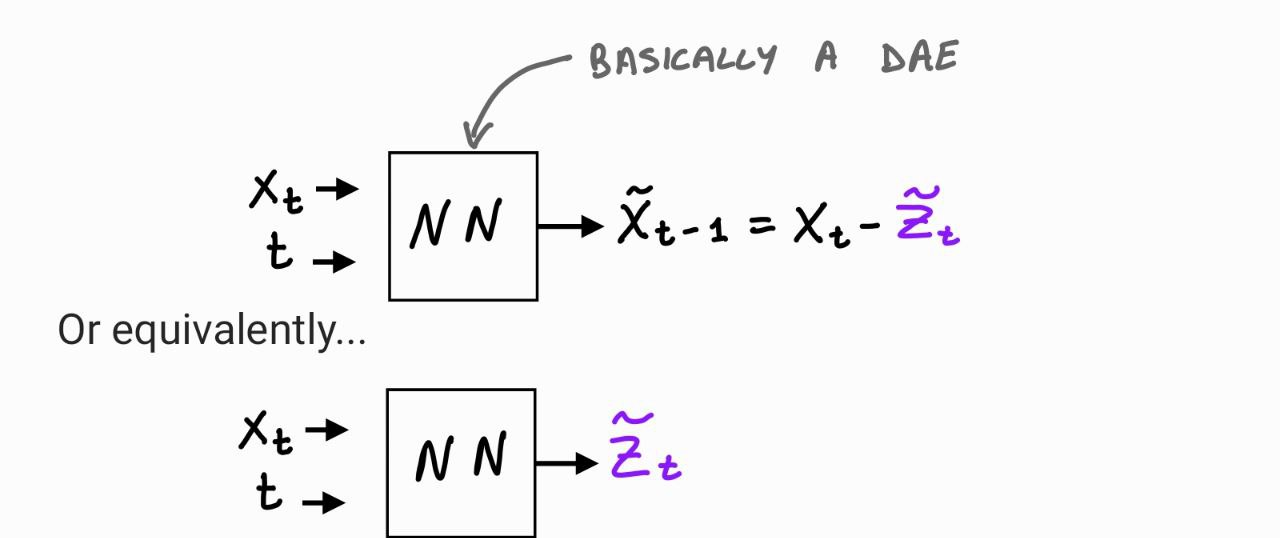
</div>

As NN, we use a Unet.

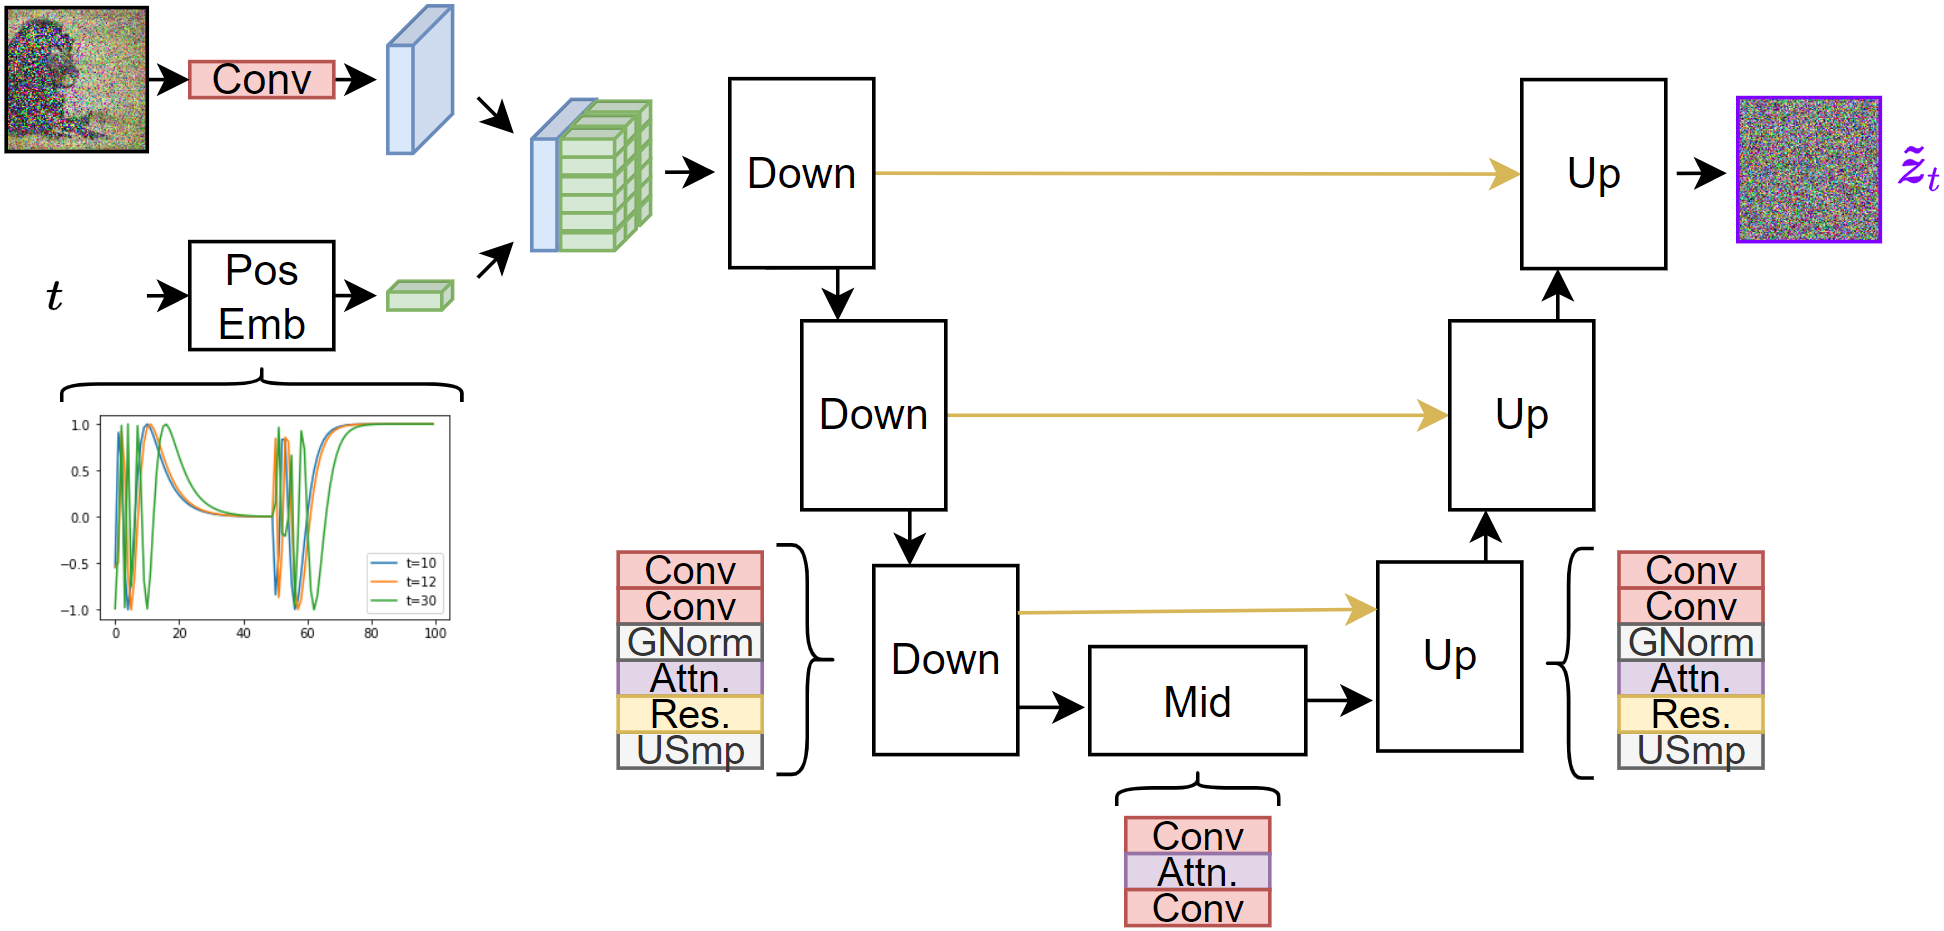

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


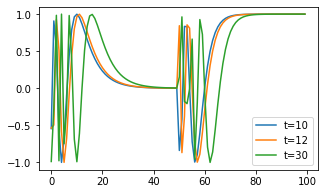

In [110]:
from scripts.unet import SinusoidalPositionEmbeddings

time_emb = SinusoidalPositionEmbeddings(100)
t1 = time_emb(torch.tensor([10]))
t2 = time_emb(torch.tensor([12]))
t3 = time_emb(torch.tensor([30]))

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(t1.numpy()[0], label='t=10')
ax.plot(t2.numpy()[0], label='t=12')
ax.plot(t3.numpy()[0], label='t=30')
plt.legend()

In [117]:
from scripts.unet import Unet

temp_model = Unet(
    dim=image_size,
    channels=3,
    dim_mults=(1, 2, 4,)
)

with torch.no_grad():
    out = temp_model(x_start, torch.tensor([40]))
    
print(f"input shape: {x_start.shape}, output shape: { out.shape}")

input shape: torch.Size([1, 3, 128, 128]), output shape: torch.Size([1, 3, 128, 128])


### Loss

<div>
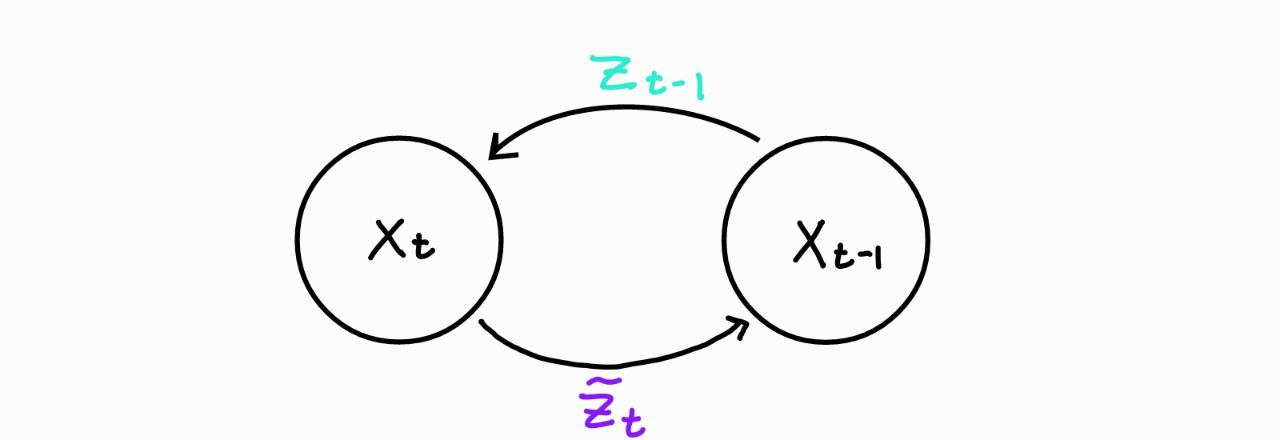
</div>



- Loss: $ \| $ <span style="color:teal"> $\boldsymbol{ z}_{t-1}$ </span> - <span style="color:purple"> $\boldsymbol{\tilde z}_{t}$ </span>  $\|_1  = \| $ <span style="color:teal"> $\boldsymbol{ z}_{t-1}$ </span> - <span style="color:purple"> NN$(\boldsymbol{x}_t, t)$ </span>  $\|_1$
- <span style="color:teal"> $\boldsymbol{ z}_{t-1}$ </span> is the noise used to compute $\boldsymbol{x}_t$ in the forward process
- Remember that to compute $\boldsymbol{x}_t$ we dropped the time index on $\boldsymbol{z}$ (nice property):
$$ \boldsymbol{x}_t = \sqrt{\bar \alpha_t} \boldsymbol{x}_0 + \sqrt{1 - \bar \alpha_t} \boldsymbol{z} $$


### Training

<div>
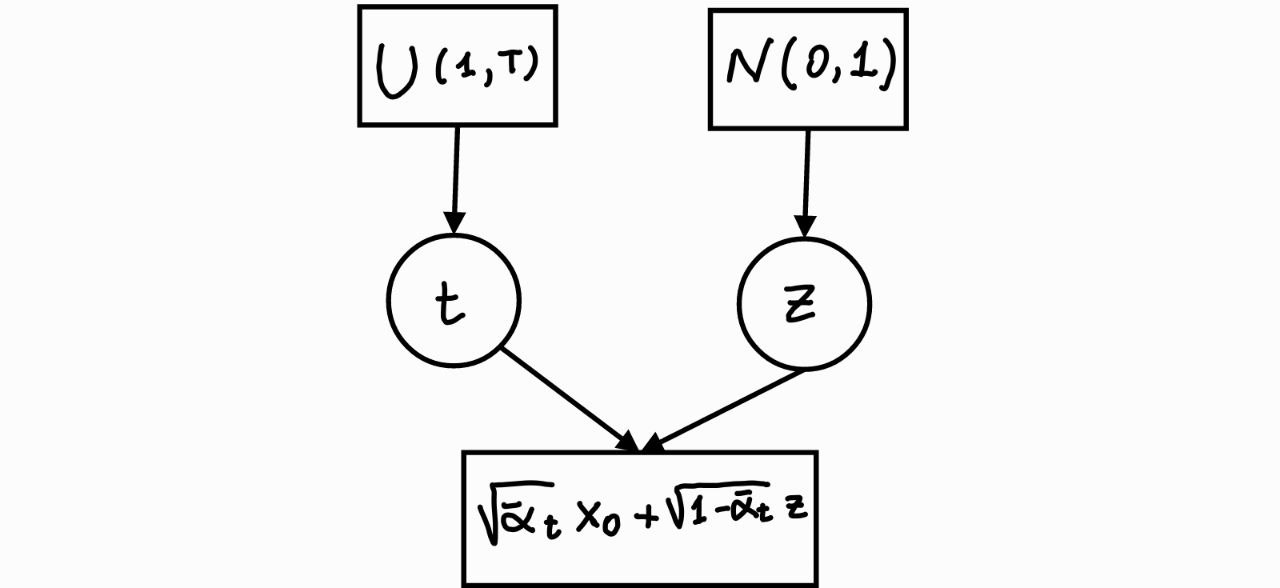
</div>

**repeat**
- $\boldsymbol{x}_0 \sim p(\boldsymbol{x}_0)$
- $t \sim \mathcal{U}([1, T])$
- $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$
- Sample <span style="color:teal"> $\boldsymbol{ z}$ </span> and $t$ randomly during training
- Take gradient descent step on
$ \nabla_\theta \|$ 
<span style="color:teal"> $\boldsymbol{ z}$ </span> - 
<span style="color:purple">
    NN$( \sqrt{\bar \alpha_t} \boldsymbol{x}_0 + \sqrt{1 - \bar \alpha_t}$
</span>
<span style="color:teal">
    $\boldsymbol{z}$
</span>
<span style="color:purple">    
    $)$
</span>
$\|_1 $

**until** converged

In [118]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

### Sampling

<div>
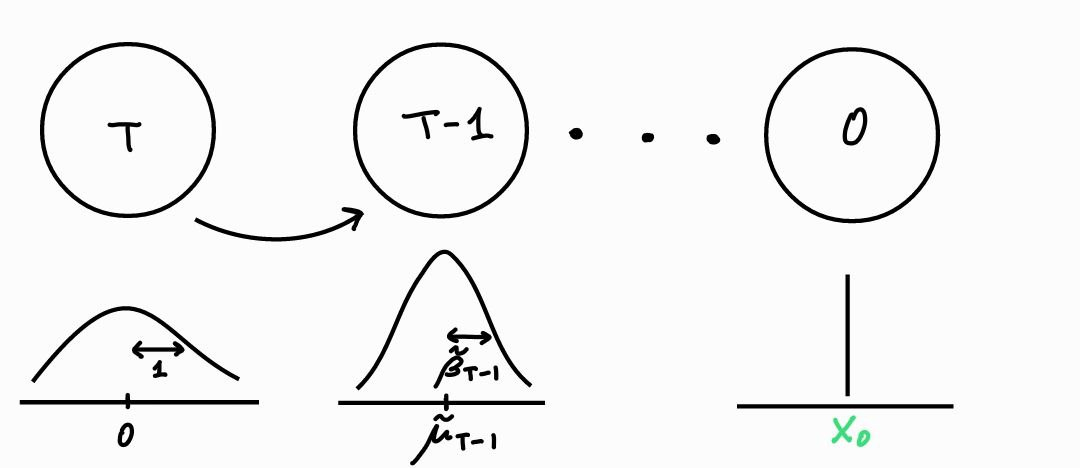
</div>

$\boldsymbol{x}_T \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$
**for** $t=T, \dots, 1$ **do**
- $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ if $t > 1$ else $\boldsymbol{z}=0$
- $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \big( \boldsymbol{x}_{t} - \frac{1 -\alpha_t}{\sqrt{1 - \bar{ \alpha}_t}}$ <span style="color:purple"> NN$(\boldsymbol{x}_t, t)$ </span> $\big) + \tilde \beta_t \boldsymbol{z}$

**return** <span style="color:green"> $\boldsymbol{x}_{0}$ </span>

In [120]:
# calculations for posterior q(x_{t-1} | x_t, x_0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # x_{t-1}
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

In [121]:
# Sampling algorithm
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

### Train the model on Fashion MNIST

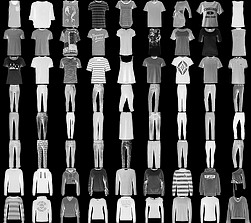

In [123]:
from datasets import load_dataset

dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Extracting data files: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.93it/s]


Dataset fashion_mnist downloaded and prepared to C:\Users\fmbia\.cache\huggingface\datasets\fashion_mnist\fashion_mnist\1.0.0\8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.19it/s]


Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the with_transform functionality for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [125]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [122]:
# from pathlib import Path

# def num_to_groups(num, divisor):
#     groups = num // divisor
#     remainder = num % divisor
#     arr = [divisor] * groups
#     if remainder > 0:
#         arr.append(remainder)
#     return arr

# results_folder = Path("./results")
# results_folder.mkdir(exist_ok = True)
# save_and_sample_every = 1000

In [124]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [126]:
from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

#       # save generated images
#       if step != 0 and step % save_and_sample_every == 0:
#         milestone = step // save_and_sample_every
#         batches = num_to_groups(4, batch_size)
#         all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
#         all_images = torch.cat(all_images_list, dim=0)
#         all_images = (all_images + 1) * 0.5
#         save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.4925515949726105
Loss: 0.14065997302532196
Loss: 0.0917077511548996
Loss: 0.06910978257656097
Loss: 0.0550425685942173
Loss: 0.061174776405096054
Loss: 0.05254824087023735
Loss: 0.05119863152503967
Loss: 0.046876389533281326
Loss: 0.05518505349755287
Loss: 0.0438351035118103
Loss: 0.055707111954689026
Loss: 0.057827744632959366
Loss: 0.05588385462760925
Loss: 0.05795704573392868
Loss: 0.04918454587459564
Loss: 0.043505147099494934
Loss: 0.045316677540540695
Loss: 0.03676053509116173
Loss: 0.045984648168087006
Loss: 0.049737103283405304
Loss: 0.03838295117020607
Loss: 0.0443778894841671
Loss: 0.04645128175616264
Loss: 0.036320146173238754


### Inference

Once trained, we can sample from the model using the function defined above:

sampling loop time step: 100%|███████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.38it/s]


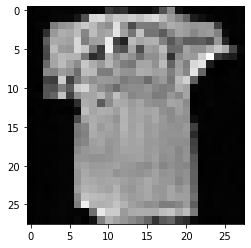

In [129]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 40
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

Visualize the actual denoising process with an animation

MovieWriter ffmpeg unavailable; using Pillow instead.


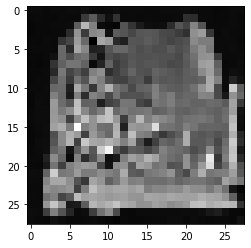

In [130]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()